In [1]:
from tensorflow import keras

## Data import
import numpy as np
import mne

# EEGNet-specific imports
from keras import utils as np_utils
from keras import backend as K

In [2]:
folder_path_string = "BCICIV_2a_gdf/"

file_path_string = folder_path_string + "A01T.gdf"
evaluation_path_string = folder_path_string + "A01T.evt"

raws = []

In [3]:
# while the default tensorflow ordering is 'channels_last' we set it here
# to be explicit in case if the user has changed the default ordering
K.set_image_data_format('channels_last')

##################### Process, filter and epoch the data ######################
raw_fname = file_path_string
event_fname = evaluation_path_string
tmin, tmax = -0., 1

# Setup for reading the raw data
raw = mne.io.read_raw_gdf(raw_fname)
raw.load_data()

#original filter
raw.filter(2, None, method='iir')  # replace baselining with high-pass

events, event_ids = mne.events_from_annotations(raw)
event_id = events[1]
print("event_id ",event_id)
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                       exclude='bads')
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False)

# Read epochs
stims =[value for key, value in event_ids.items() if key in ('769','770','771','772')]
epochs = mne.Epochs(raw, events, stims, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)
channels_to_remove = ['EOG-left', 'EOG-central', 'EOG-right']
epochs = epochs.drop_channels(channels_to_remove)
labels = epochs.events[:, -1]
print(epochs)

# extract raw data. scale by 1000 due to scaling sensitivity in deep learning
X = epochs.get_data()*1000 # format is in (trials, channels, samples)
y = labels
y[y == 7] = 0
y[y == 8] = 1
y[y == 9] = 2
y[y == 10] = 3

kernels, chans, samples = 1, X.shape[1], X.shape[2]

# take 50/25/25 percent of the data to train/validate/test

train_idx = round(X.shape[0] * 0.8)
#test_idx = round(X.shape[0] * 0.75)

X_train      = X[0:train_idx,]
Y_train      = y[0:train_idx]
#X_validate   = X[train_idx:test_idx,]
#Y_validate   = y[train_idx:test_idx]
X_test       = X[train_idx:,]
Y_test       = y[train_idx:]

############################# EEGNet portion ##################################

# convert labels to one-hot encodings.
y_unique = np.unique(y)
num_classes = len(y_unique)
Y_train      = np_utils.to_categorical(Y_train-1, num_classes=num_classes)
#Y_validate   = np_utils.to_categorical(Y_validate-1, num_classes=num_classes)
Y_test       = np_utils.to_categorical(Y_test-1, num_classes=num_classes)

# convert data to NHWC (trials, channels, samples, kernels) format. Data
# contains 60 channels and 151 time-points. Set the number of kernels to 1.
X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
#X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)

print("X.Shape", X.shape)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print("y.Shape", y.shape)
print('y_train shape:', Y_train.shape)
print('y_test shape:', Y_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print('num_classes:', num_classes)

Extracting EDF parameters from C:\Users\Lars\Desktop\transformer\Transformer for TimeSeries Data\BCICIV_2a_gdf\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\users\lars\appdata\local\programs\python\python37\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
c:\users\lars\appdata\local\programs\python\python37\lib\contextlib.py:119: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 2.00 Hz: -6.02 dB

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
event_id  [0 0 3]
<Epochs |  288 events (all good), 0 - 1 sec, baseline off, ~12.2 MB, data loaded,
 '7': 72
 '8': 72
 '9': 72
 '10': 72>
X.Shape (288, 22, 251)
X_train shape: (230, 22, 251, 1)
X_test shape: (58, 22, 251, 1)
y.Shape (288,)
y_train shape: (230, 4)
y_test shape: (58, 4)
230 train samples
58 test samples
num_classes: 4


## Build the model

Our model processes a tensor of shape `(batch size, sequence length, features)`,
where `sequence length` is the number of time steps and `features` is each input
timeseries.

You can replace your classification RNN layers with this one: the
inputs are fully compatible!

We include residual connections, layer normalization, and dropout.
The resulting layer can be stacked multiple times.

The projection layers are implemented through `keras.layers.Conv1D`.

In [4]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = keras.layers.Dropout(dropout)(x)
    x = keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

The main part of our model is now complete. We can stack multiple of those
`transformer_encoder` blocks and we can also proceed to add the final
Multi-Layer Perceptron classification head. Apart from a stack of `Dense`
layers, we need to reduce the output tensor of the `TransformerEncoder` part of
our model down to a vector of features for each data point in the current
batch. A common way to achieve this is to use a pooling layer. For
this example, a `GlobalAveragePooling1D` layer is sufficient.

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = keras.layers.GlobalAveragePooling2D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = keras.layers.Dense(dim, activation="relu")(x)
        x = keras.layers.Dropout(mlp_dropout)(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## Train and evaluate

In [6]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=64,
    num_heads=2,
    ff_dim=4,
    num_transformer_blocks=1,
    mlp_units=[8],
    mlp_dropout=0.4,
    dropout=0.25,
)

keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [7]:
'''model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)'''
# compile the model and set the optimizers
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics = ['accuracy', 'TruePositives', 'TrueNegatives'])
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 22, 251, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 multi_head_attention (MultiHea  (None, 22, 251, 1)  897         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 22, 251, 1)   0           ['multi_head_attention[0][0]']   
                                                                                              

In [8]:
history = model.fit(
    X_train,
    Y_train,
    validation_split=0.2,
    epochs=2,
    batch_size=2,
    callbacks=callbacks,
)

#model.evaluate(X_test, Y_test, verbose=1)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
92/92 [==============================] - ETA: 0s - loss: 1.3872 - accuracy: 0.2283 - true_positives: 0.0000e+00 - true_negatives: 552.0000WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001BAF89D05E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbo

In [ ]:
model.evaluate(X_test, Y_test, verbose=1)

In [10]:
print(history.history)

{'loss': [1.3885267972946167, 1.3870253562927246], 'accuracy': [0.27826085686683655, 0.25217390060424805], 'true_positives': [0.0, 0.0], 'true_negatives': [345.0, 345.0], 'val_loss': [1.3871972560882568, 1.386379599571228], 'val_accuracy': [0.2068965584039688, 0.2068965584039688], 'val_true_positives': [0.0, 0.0], 'val_true_negatives': [87.0, 87.0]}


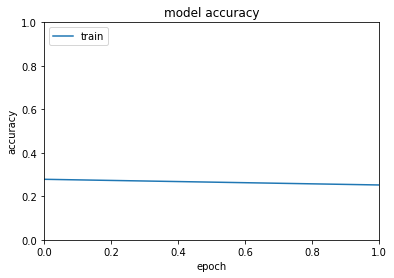

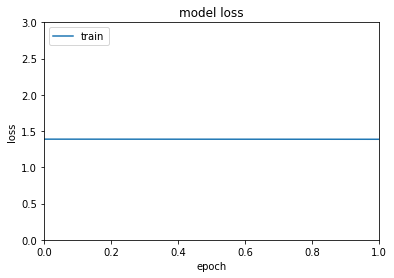

In [13]:
from matplotlib import pyplot as plt  # summarize history for accuracy
plt.figure()
plt.plot(history.history['accuracy'])
plt.axis([0,1,0,1])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.axis([0,1,0,3])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()